In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content


In [0]:
import os
os.chdir('/content/drive/My Drive/gc2ae/SN_keras/')
!ls

CBN.py				    model.py
CIFAR10-ResNet-CrammerSinger.ipynb  models
CIFAR10-ResNet.ipynb		    __pycache__
data_utils.py			    pyimagesearch
GC2AE-CrammerSinger-FM.ipynb	    ResNet-CrammerSinger-FM.ipynb
GC2AE-CS-FM_Reconstruct.ipynb	    SpectralNormalizationKeras.py
img				    test_GC2AE.ipynb
losses				    train_Classifier.ipynb


In [0]:
!pip install keras==2.1.5
%tensorflow_version 1.x
import keras
keras.__version__

     |████████████████████████████████| 337kB 2.8MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1
TensorFlow 1.x selected.


Using TensorFlow backend.


'2.1.5'

In [0]:
%matplotlib inline
import keras.backend as K
K.tensorflow_backend._get_available_gpus()

import numpy as np
import matplotlib.pyplot as plt
from time import time

from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
import keras.backend as K
from keras.utils.generic_utils import Progbar

from sklearn.utils import shuffle
import joblib

from model import *

In [0]:
from data_utils import onehotencode,sample_known_unknown_classes,\
sample_mismatch_labels,sample_mismatch_images,get_classwise, get_mapped_labels

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [0]:
# for resist GPU memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

In [0]:
from keras.datasets import cifar100, cifar10, mnist

In [0]:
#_,known_classes,unknown_classes = sample_known_unknown_classes(10,6)

known_classes = [9, 6, 0, 5, 3, 7]
unknown_classes = [8, 1, 2, 4]

known_class_mapping = {}
known_class_mapping_inv = {}
i=0
for kc in known_classes:
    known_class_mapping[kc] = i
    known_class_mapping_inv[i] = kc
    i+=1

In [0]:
def get_mismatch_data(x_known_classwise,y_known,known_classes,known_class_mapping):
    #Sample mismatch labels
    y_known_mismatch = sample_mismatch_labels(y_known,known_classes)
    #Sample mismatch images
    x_known_mismatch = sample_mismatch_images(x_known_classwise,y_known_mismatch)
    #Generate mapped labels
    y_known_mismatch_mapped = get_mapped_labels(y_known_mismatch,known_class_mapping)
    #Onehotencode mapped labels
    y_known_mismatch_mapped_ohe = onehotencode(y_known_mismatch_mapped+1,wgan=True)
    
    #Reshape arrays
    y_known_mismatch = y_known_mismatch.reshape((y_known_mismatch.shape[0],1))
    y_known_mismatch_mapped = y_known_mismatch_mapped.reshape((y_known_mismatch_mapped.shape[0],1))    
    if len(x_known_mismatch.shape)<4:
        x_known_mismatch = np.expand_dims(x_known_mismatch,axis=-1)
    
    return (x_known_mismatch, y_known_mismatch, y_known_mismatch_mapped, y_known_mismatch_mapped_ohe)

def get_known_unknown_data(x,y,known_classes,known_class_mapping,unknown_classes,unknown=False):
    #Known - Match
    y_known = y[np.where(np.isin(y,known_classes))]
    x_known = x[np.where(np.isin(y,known_classes))]
    
    x_known_classwise = get_classwise(x_known,y_known,known_classes)
    
    #Generate mapped labels
    y_known_mapped = get_mapped_labels(y_known,known_class_mapping)
    #Onehotencode mapped labels
    y_known_mapped_ohe = onehotencode(y_known_mapped+1,wgan=True)
    
    #Reshape arrays
    y_known = y_known.reshape((y_known.shape[0],1))
    y_known_mapped = y_known_mapped.reshape((y_known_mapped.shape[0],1))
    if len(x_known.shape)<4:
        x_known = np.expand_dims(x_known,axis=-1)
    
    #Known - Mismatch
    x_known_mismatch, y_known_mismatch,\
    y_known_mismatch_mapped, y_known_mismatch_mapped_ohe = get_mismatch_data(x_known_classwise,
                                                                             y_known,known_classes,
                                                                             known_class_mapping)        
    #Unknown
    if unknown:
        #y_unknown = y[np.where(np.isin(y,unknown_classes))]
        x_unknown = x[np.where(np.isin(y,unknown_classes))]

        if len(x_unknown.shape)<4:
            x_unknown = np.expand_dims(x_unknown,axis=-1)
            
        return (x_known, x_known_classwise, y_known, y_known_mapped, y_known_mapped_ohe), \
                (x_known_mismatch, y_known_mismatch, y_known_mismatch_mapped, y_known_mismatch_mapped_ohe),\
                (x_unknown)

    return (x_known, x_known_classwise, y_known, y_known_mapped, y_known_mapped_ohe), \
            (x_known_mismatch, y_known_mismatch, y_known_mismatch_mapped, y_known_mismatch_mapped_ohe)

In [0]:
#Hyperperemeter
BATCHSIZE=64
LEARNING_RATE = 0.0002
TRAINING_RATIO = 2
BETA_1 = 0.0
BETA_2 = 0.9
EPOCHS = 500
BN_MIMENTUM = 0.9
BN_EPSILON  = 0.00002
SAVE_DIR = 'img/test/'

NUM_CLASSES = 10

LATENT_DIM = 128

USE_NOISE_GENERATOR = False

IMG_SHAPE = (28,28,1)

GENERATE_ROW_NUM = 8
GENERATE_BATCHSIZE = GENERATE_ROW_NUM*GENERATE_ROW_NUM

In [0]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

def crammer_singer_criterion(y_true, y_pred):
    mask = tf.math.equal(y_true,1) #Get indices for target labels
    mask_inv = tf.logical_not(mask) #Get indices for other labels
    
    shape1 = tf.stack((tf.shape(y_pred)[0],))
    shape2 = tf.stack((tf.shape(y_pred)[0],tf.shape(y_pred)[1]-1))
    
    #Predicted values for target label
    target = tf.reshape(tf.boolean_mask(y_pred,mask),shape1) 
    
    #Max predicted value for wrong label
    max_wrong = tf.math.reduce_max(tf.reshape(tf.boolean_mask(y_pred,mask_inv),
                                              shape2),axis=1)
    
    return tf.reduce_mean(tf.nn.relu(1 + max_wrong - target))

def fm_loss(y_true, y_pred):
    target_features_mean = tf.reduce_mean(y_true,axis=0)
    pred_features_mean = tf.reduce_mean(y_pred,axis=0)
    abs_diff = tf.math.abs(target_features_mean - pred_features_mean)
    return tf.reduce_mean(abs_diff)

In [0]:
def auroc(y_true, y_pred):
    try:
        return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)
    except:
        return -1

classifier = load_model('models/classifier/MNIST/classifier-save-20-0.002-0.030.hdf5',
                        custom_objects={'GlobalSumPooling2D':GlobalSumPooling2D,
                                        'auroc':auroc})
classifier.summary()











Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_______________________

In [0]:
#encoder = BuildEncoder(in_shape = IMG_SHAPE, latent_dim=LATENT_DIM)
encoder = classifier.layers[1]
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
Discriminator_resblock_Down_ (None, 14, 14, 128)       149636    
_________________________________________________________________
Discriminator_resblock_Down_ (None, 7, 7, 128)         312704    
_________________________________________________________________
Discriminator_resblock_1 (Mo (None, 7, 7, 128)         296192    
_________________________________________________________________
Discriminator_resblock_2 (Mo (None, 7, 7, 128)         296192    
_________________________________________________________________
activation_9 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
global_sum_pooling2d_1 (Glob (None, 128)               0         
Total para

In [0]:
#CIFAR
#generator = BuildGenerator(bn_momentum=BN_MIMENTUM, bn_epsilon=BN_EPSILON,cbn=CBN)
#discriminator = BuildDiscriminator(cbn=CBN)

GENERATOR_NOISE = False

#MNIST
generator = BuildGenerator(cbn=NUM_CLASSES,resblock3=False,
                           noise=GENERATOR_NOISE,
                           spectral_normalization=True,
                           out_channels=1,init_shape=(7,7,256),
                           in_shape=(LATENT_DIM,))
#CS LOSS
discriminator, discriminator_feat = BuildDiscriminatorCS(num_classes=len(known_classes),
                                                         in_shape=IMG_SHAPE,
                                                         feat=True)



Generator
Spectral Normalization: True
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
dense_sn_1 (DenseSN)            (None, 12544)        1630720     input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 7, 7, 256)    0           dense_sn_1[0][0]                 
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
____________________________________________________________________

In [0]:
Image_input_for_encoder = Input(shape=IMG_SHAPE)
Encoder_output = encoder(Image_input_for_encoder)

if GENERATOR_NOISE:
    Noise_input_for_training_generator = Input(shape=(LATENT_DIM,))

#Merged_inputs = Concatenate()([Encoder_output,
#                              Noise_input_for_training_generator])

Match_class_input_for_training_generator = Input(shape=(1,),dtype='int32')
Mismatch_class_input_for_training_generator = Input(shape=(1,),dtype='int32')

if GENERATOR_NOISE:
    Match_Generated_image = generator([Encoder_output,
                                    Noise_input_for_training_generator,
                                    Match_class_input_for_training_generator])
    Mismatch_Generated_image = generator([Encoder_output,
                                        Noise_input_for_training_generator,
                                        Mismatch_class_input_for_training_generator])
else:
    Match_Generated_image = generator([Encoder_output,
                                    Match_class_input_for_training_generator])
    Mismatch_Generated_image = generator([Encoder_output,
                                        Mismatch_class_input_for_training_generator])


Match_discriminator_output = discriminator(Match_Generated_image)
Match_discriminator_feat_output = discriminator_feat(Match_Generated_image)

Mismatch_discriminator_output = discriminator(Mismatch_Generated_image)
Mismatch_discriminator_feat_output = discriminator_feat(Mismatch_Generated_image)

if GENERATOR_NOISE:
    model_for_training_generator = Model([Image_input_for_encoder,
                                        Noise_input_for_training_generator,
                                        Match_class_input_for_training_generator,
                                        Mismatch_class_input_for_training_generator], 
                                        [Match_discriminator_output, 
                                        Match_discriminator_feat_output,
                                        Mismatch_discriminator_output, 
                                        Mismatch_discriminator_feat_output,
                                        Match_Generated_image,
                                        Mismatch_Generated_image])
    
else:
    model_for_training_generator = Model([Image_input_for_encoder,
                                        Match_class_input_for_training_generator,
                                        Mismatch_class_input_for_training_generator], 
                                        [Match_discriminator_output, 
                                        Match_discriminator_feat_output,
                                        Mismatch_discriminator_output, 
                                        Mismatch_discriminator_feat_output,
                                        Match_Generated_image,
                                        Mismatch_Generated_image])


print("model_for_training_generator")
encoder.trainable=False
discriminator.trainable = False
discriminator_feat.trainable = False
model_for_training_generator.summary()

#lmbda = 0.05 #CS Loss Weight
lmbda = 0.95 #FM Loss Weight
beta = 0.7 #Match weight

gamma = 1. #Reconstruction weight

#Upscale the loss
#lmbda *= 10
#beta *= 10

model_for_training_generator.compile(optimizer=Adam(LEARNING_RATE, 
                                                    beta_1=BETA_1, 
                                                    beta_2=BETA_2), 
                                     loss=[crammer_singer_criterion,fm_loss,
                                           crammer_singer_criterion,fm_loss,
                                           'mean_squared_error',
                                           'mean_squared_error'],
                                     loss_weights=[beta*(1-lmbda),
                                                   beta*lmbda,
                                                   (1-beta)*(1-lmbda),
                                                   (1-beta)*lmbda,
                                                   gamma,
                                                   gamma])

model_for_training_generator
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
Encoder_Encoder (Model)         (None, 128)          1054724     input_12[0][0]                   
__________________________________________________________________________________________________
input_13 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 1)            0                                            
________________________________________________________________________________

In [0]:
#WLOSS
Real_image = Input(shape=IMG_SHAPE)
Mismatch_Real_image = Input(shape=IMG_SHAPE)

Match_class_input_for_training_generator = Input(shape=(1,),dtype='int32')
Mismatch_class_input_for_training_generator = Input(shape=(1,),dtype='int32')

Encoder_output = encoder(Real_image)

if GENERATOR_NOISE:
    Noise_input_for_training_discriminator = Input(shape=(LATENT_DIM,))


#Merged_inputs = Concatenate()([Encoder_output,
#                              Noise_input_for_training_discriminator])

if GENERATOR_NOISE:
    Match_Fake_image = generator([Encoder_output,
                                Noise_input_for_training_discriminator,
                                Match_class_input_for_training_generator])
    Mismatch_Fake_image = generator([Encoder_output,
                                    Noise_input_for_training_discriminator,
                                    Mismatch_class_input_for_training_generator])
else:
    Match_Fake_image = generator([Encoder_output,
                                Match_class_input_for_training_generator])
    Mismatch_Fake_image = generator([Encoder_output,
                                    Mismatch_class_input_for_training_generator])


Discriminator_output_for_real = discriminator(Real_image)
Discriminator_output_for_mismatch_real = discriminator(Mismatch_Real_image)

Discriminator_output_for_match_fake = discriminator(Match_Fake_image)
Discriminator_output_for_mismatch_fake = discriminator(Mismatch_Fake_image)

if GENERATOR_NOISE:
    model_for_training_discriminator = Model([Real_image,
                                            Mismatch_Real_image,
                                            Noise_input_for_training_discriminator,
                                            Match_class_input_for_training_generator,
                                            Mismatch_class_input_for_training_generator],
                                            [Discriminator_output_for_real,
                                            Discriminator_output_for_mismatch_real,
                                            Discriminator_output_for_match_fake,
                                            Discriminator_output_for_mismatch_fake])
else:
    model_for_training_discriminator = Model([Real_image,
                                            Mismatch_Real_image,
                                            Match_class_input_for_training_generator,
                                            Mismatch_class_input_for_training_generator],
                                            [Discriminator_output_for_real,
                                            Discriminator_output_for_mismatch_real,
                                            Discriminator_output_for_match_fake,
                                            Discriminator_output_for_mismatch_fake])


print("model_for_training_discriminator")
encoder.trainable = False
generator.trainable = False
discriminator_feat.trainable=True
discriminator.trainable = True
model_for_training_discriminator.compile(optimizer=Adam(LEARNING_RATE, 
                                                        beta_1=BETA_1, 
                                                        beta_2=BETA_2), 
                                         loss=[crammer_singer_criterion,
                                               crammer_singer_criterion, 
                                               crammer_singer_criterion,
                                               crammer_singer_criterion])
model_for_training_discriminator.summary()

model_for_training_discriminator
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
Encoder_Encoder (Model)         (None, 128)          1054724     input_15[0][0]                   
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 1)            0                                            
____________________________________________________________________________

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = (x_train - 127.5)/127.5
x_test = (x_test - 127.5)/127.5

assert (np.min(x_train) == -1) and (np.max(x_train) == 1)
assert (np.min(x_test) == -1) and (np.max(x_test) == 1)

(x_train_known,x_train_known_classwise,y_train_known,y_train_known_mapped,y_train_known_mapped_ohe),\
(x_train_known_mismatch, y_train_known_mismatch, y_train_known_mismatch_mapped, y_train_known_mismatch_mapped_ohe),\
(x_train_unknown) = get_known_unknown_data(x_train,y_train,known_classes,known_class_mapping,unknown_classes,unknown=True)

(x_test_known,x_test_known_classwise,y_test_known,y_test_known_mapped,y_test_known_mapped_ohe),\
(x_test_known_mismatch, y_test_known_mismatch, y_test_known_mismatch_mapped, y_test_known_mismatch_mapped_ohe),\
(x_test_unknown) = get_known_unknown_data(x_test,y_test,known_classes,known_class_mapping,unknown_classes,unknown=True)

11493376/11490434 [==============================] - 2s 0us/step


In [0]:
fake_y = np.ones_like(y_train_known_mismatch_mapped_ohe)*-1
fake_y[:,0] = 1

print(y_train_known_mismatch_mapped[:5])
print()
print(y_train_known_mismatch_mapped_ohe[:5])
print()
print(fake_y[:5])

assert np.sum(y_train_known_mismatch_mapped_ohe[:,0])*-1 == len(y_train_known_mismatch_mapped_ohe)
assert np.sum(fake_y[:,0]) == len(fake_y)

[[0]
 [5]
 [3]
 [3]
 [1]]

[[-1  1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1  1]
 [-1 -1 -1 -1  1 -1 -1]
 [-1 -1 -1 -1  1 -1 -1]
 [-1 -1  1 -1 -1 -1 -1]]

[[ 1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1]]


In [0]:
test_noise = np.random.randn(int(GENERATE_BATCHSIZE/2), LATENT_DIM)

test_class = y_train_known_mapped[:int(GENERATE_BATCHSIZE/2)]
test_class_ohe = y_train_known_mapped_ohe[:int(GENERATE_BATCHSIZE/2)]
test_images = x_train_known[:int(GENERATE_BATCHSIZE/2)]
test_image_embeddings = encoder.predict(test_images)

test_mismatch_class = y_train_known_mismatch_mapped[:int(GENERATE_BATCHSIZE/2)]
test_mismatch_class_ohe = y_train_known_mismatch_mapped_ohe[:int(GENERATE_BATCHSIZE/2)]
test_mismatch_images = x_train_known_mismatch[:int(GENERATE_BATCHSIZE/2)]
test_mismatch_image_embeddings = encoder.predict(test_mismatch_images)

test_mismatch_noise = np.random.randint(0,255,test_images.shape).astype(test_images.dtype)
test_mismatch_noise = (test_mismatch_noise - 127.5)/127.5

test_fake_ohe = fake_y[:int(GENERATE_BATCHSIZE/2)]

print(test_class.reshape((test_class.shape[0],)))

test_match_inputs = [test_image_embeddings,test_class]
test_mismatch_inputs = [test_image_embeddings,test_mismatch_class]
if GENERATOR_NOISE:
    test_match_inputs = [test_image_embeddings,test_noise,test_class]
    test_mismatch_inputs = [test_image_embeddings,test_noise,test_mismatch_class]

[3 2 0 4 4 3 4 1 5 1 0 2 0 4 5 4 1 0 2 3 1 2 5 1 5 0 4 0 3 0 4 4]


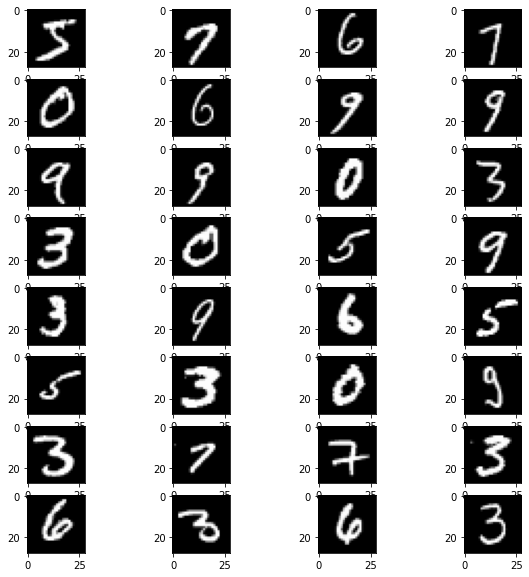

In [0]:
idx = 0
nrows = 8
ncols = int(GENERATE_BATCHSIZE/(2*nrows))
fig=plt.figure(figsize=(10, 10))

i=0
idxs = [0, 4, 8, 12, 16, 20, 24, 28]
for col in range(ncols):
    for idx in idxs:
        fig.add_subplot(nrows, ncols, idx+col+1)
        plt.imshow(test_images[i].reshape(28,28), cmap='gray')
        i+=1

# for row in range(nrows):
#     for col in range(ncols):
#         idx = row*ncols + col
#         fig.add_subplot(nrows, ncols, idx+1)
#         plt.imshow(test_images[idx].reshape(28,28), cmap='gray')
        
plt.show()

In [0]:
EPOCHS=150

In [0]:
image_dim = 28 #32
image_channels = 1 #3
CS_loss = []
discriminator_loss = []
generator_loss = []
for epoch in range(EPOCHS):
    
    x_known_mismatch, y_known_mismatch,\
    y_known_mismatch_mapped,\
    y_known_mismatch_mapped_ohe = get_mismatch_data(x_train_known_classwise,
                                                    y_train_known,known_classes,
                                                    known_class_mapping)

    x_train_known, y_train_known,\
    y_train_known_mapped, y_train_known_mapped_ohe,\
    x_train_known_mismatch, y_train_known_mismatch,\
    y_train_known_mismatch_mapped,\
    y_train_known_mismatch_mapped_ohe = shuffle(x_train_known, y_train_known,
                                                y_train_known_mapped, 
                                                y_train_known_mapped_ohe,
                                                x_train_known_mismatch,
                                                y_train_known_mismatch, 
                                                y_train_known_mismatch_mapped, 
                                                y_train_known_mismatch_mapped_ohe)
    #X,Y,real_y = shuffle(X,Y,real_y)
    
    print("epoch {} of {}".format(epoch+1, EPOCHS))
    num_batches = int(x_train_known.shape[0] // BATCHSIZE)
    
    print("number of batches: {}".format(int(x_train_known.shape[0] // (BATCHSIZE))))
    
    progress_bar = Progbar(target=int(x_train_known.shape[0] // (BATCHSIZE * TRAINING_RATIO)))
    minibatches_size = BATCHSIZE * TRAINING_RATIO
    
    start_time = time()
    for index in range(int(x_train_known.shape[0] // (BATCHSIZE * TRAINING_RATIO))):
        progress_bar.update(index)
        
        minibatches_X = x_train_known[index * minibatches_size:(index + 1) * minibatches_size]
        minibatches_Y = y_train_known_mapped[index * minibatches_size:(index + 1) * minibatches_size]
        minibatches_Y_ohe = y_train_known_mapped_ohe[index * minibatches_size:(index + 1) * minibatches_size]
        
        minibatches_mismatch_X = x_train_known_mismatch[index * minibatches_size:(index + 1) * minibatches_size]
        minibatches_mismatch_Y = y_train_known_mismatch_mapped[index * minibatches_size:(index + 1) * minibatches_size]
        minibatches_mismatch_Y_ohe = y_train_known_mismatch_mapped_ohe[index * minibatches_size:(index + 1) * minibatches_size]
        
        #minibatches_real_y = real_y[index * minibatches_size:(index + 1) * minibatches_size]
        minibatches_fake_y = fake_y[index * minibatches_size:(index + 1) * minibatches_size]
        
        for j in range(TRAINING_RATIO):
            image_batch = minibatches_X[j * BATCHSIZE : (j + 1) * BATCHSIZE]
            match_class_batch = minibatches_Y[j * BATCHSIZE : (j + 1) * BATCHSIZE]
            match_class_batch_ohe = minibatches_Y_ohe[j * BATCHSIZE : (j + 1) * BATCHSIZE]
            
            mismatch_image_batch = minibatches_mismatch_X[j * BATCHSIZE : (j + 1) * BATCHSIZE]
            mismatch_class_batch = minibatches_mismatch_Y[j * BATCHSIZE : (j + 1) * BATCHSIZE]
            mismatch_class_batch_ohe = minibatches_mismatch_Y_ohe[j * BATCHSIZE : (j + 1) * BATCHSIZE]
            
            #real_y_batch = minibatches_real_y[j * BATCHSIZE : (j + 1) * BATCHSIZE]
            
            fake_y_batch = minibatches_fake_y[j * BATCHSIZE : (j + 1) * BATCHSIZE]
            
            noise = np.random.randn(BATCHSIZE, 128).astype(np.float32)
            
            discriminator_feat.trainable = True
            discriminator.trainable = True
            generator.trainable = False
            
            disc_inputs = [image_batch,mismatch_image_batch,
                            match_class_batch,mismatch_class_batch]
            if GENERATOR_NOISE:
                disc_inputs = [image_batch,mismatch_image_batch,noise,
                               match_class_batch,mismatch_class_batch]

            discriminator_loss.append(model_for_training_discriminator.train_on_batch(disc_inputs,
                                                                                      [match_class_batch_ohe,
                                                                                       mismatch_class_batch_ohe,
                                                                                       fake_y_batch,
                                                                                       fake_y_batch]))
        discriminator_feat.trainable = False
        discriminator.trainable = False
        generator.trainable = True
        
        match_feat_batch = discriminator_feat.predict_on_batch(image_batch)
        #mismatch_noise = np.random.randint(0,255,mismatch_image_batch.shape).astype(mismatch_image_batch.dtype)
        #mismatch_noise = (mismatch_noise - 127.5)/127.5
        #mismatch_feat_batch = discriminator_feat.predict_on_batch(mismatch_noise)
        mismatch_feat_batch = discriminator_feat.predict_on_batch(mismatch_image_batch)
        
        gen_inputs = [image_batch,match_class_batch,mismatch_class_batch]
        if GENERATOR_NOISE:
            gen_inputs = [image_batch,np.random.randn(BATCHSIZE, 128),
                          match_class_batch,mismatch_class_batch]

        generator_loss.append(model_for_training_generator.train_on_batch(gen_inputs, 
                                                                          [match_class_batch_ohe, 
                                                                           match_feat_batch,
                                                                           mismatch_class_batch_ohe, #fake_y_batch 
                                                                           mismatch_feat_batch,
                                                                           image_batch,
                                                                           image_batch]))#mismatch_image_batch
    
    print('\nepoch time: {}'.format(time()-start_time))
        
    # test_feat_batch = discriminator_feat.predict_on_batch(test_images)
    # #test_mismatch_feat_batch = discriminator_feat.predict_on_batch(test_mismatch_images)
    # test_mismatch_feat_batch = discriminator_feat.predict_on_batch(test_mismatch_noise)
    
    # W_real = model_for_training_generator.evaluate([test_images,
    #                                                 test_noise,
    #                                                 test_class,
    #                                                 test_mismatch_class], 
    #                                                [test_class_ohe,
    #                                                 test_feat_batch,
    #                                                 test_mismatch_class_ohe, #test_fake_ohe
    #                                                 test_mismatch_feat_batch])
    # print(W_real)
    # W_fake = model_for_training_generator.evaluate([test_images,
    #                                                 test_noise,
    #                                                 test_class,
    #                                                 test_mismatch_class], 
    #                                                [test_fake_ohe,
    #                                                 test_feat_batch,
    #                                                 test_fake_ohe,
    #                                                 test_mismatch_feat_batch])
    # print(W_fake)
    # W_l = W_real+W_fake
    # print('CS_loss: {}'.format(W_l))
    # CS_loss.append(W_l)
    
    #Generate image
    generated_match_image = generator.predict(test_match_inputs)
    generated_mismatch_image = generator.predict(test_mismatch_inputs)
    
    generated_match_image = (generated_match_image+1)/2
    generated_mismatch_image = (generated_mismatch_image+1)/2
    
    generated_image = np.append(generated_match_image,generated_mismatch_image,axis=0)
    
    assert len(generated_image) == GENERATE_BATCHSIZE
    
    for i in range(GENERATE_ROW_NUM):
        if image_channels == 1:
            new = generated_image[i*GENERATE_ROW_NUM:i*GENERATE_ROW_NUM+GENERATE_ROW_NUM].reshape(image_dim*GENERATE_ROW_NUM,
                                                                                              image_dim)
        else:
            new = generated_image[i*GENERATE_ROW_NUM:i*GENERATE_ROW_NUM+GENERATE_ROW_NUM].reshape(image_dim*GENERATE_ROW_NUM,
                                                                                              image_dim,image_channels)
        if i!=0:
            old = np.concatenate((old,new),axis=1)
        else:
            old = new
    print('plot generated_image')
    
    if image_channels == 1:
        plt.imsave('{}/SN_epoch_{}.png'.format(SAVE_DIR, epoch), old, cmap='gray')
    else:
        plt.imsave('{}/SN_epoch_{}.png'.format(SAVE_DIR, epoch), old)

epoch 1 of 150
number of batches: 556
277/278 [============================>.] - ETA: 1s
epoch time: 428.28638792037964
plot generated_image
epoch 2 of 150
number of batches: 556
277/278 [============================>.] - ETA: 1s
epoch time: 387.2337749004364
plot generated_image
epoch 3 of 150
number of batches: 556
277/278 [============================>.] - ETA: 1s
epoch time: 389.9391474723816
plot generated_image
epoch 4 of 150
number of batches: 556
277/278 [============================>.] - ETA: 1s
epoch time: 391.15057468414307
plot generated_image
epoch 5 of 150
number of batches: 556
277/278 [============================>.] - ETA: 1s
epoch time: 380.75165367126465
plot generated_image
epoch 6 of 150
number of batches: 556
277/278 [============================>.] - ETA: 1s
epoch time: 350.4413387775421
plot generated_image
epoch 7 of 150
number of batches: 556
277/278 [============================>.] - ETA: 1s
epoch time: 351.45980644226074
plot generated_image
epoch 8 of 150
n

In [0]:
model_for_training_discriminator.metrics_names

['loss',
 'Discriminator_loss',
 'Discriminator_loss',
 'Discriminator_loss',
 'Discriminator_loss']

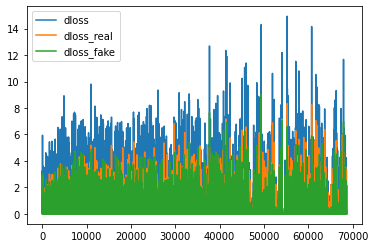

In [0]:
disc_loss = np.array(discriminator_loss)
d_loss = disc_loss[:,0]
d_loss_real = disc_loss[:,1]
d_loss_fake = disc_loss[:,2]
plt.plot(d_loss,label='dloss')
plt.plot(d_loss_real,label='dloss_real')
plt.plot(d_loss_fake,label='dloss_fake')
plt.legend(loc='best')

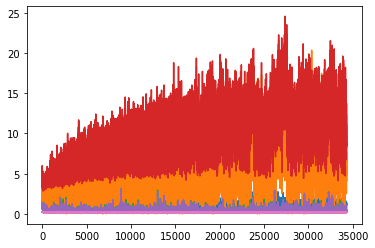

In [0]:
plt.plot(generator_loss)

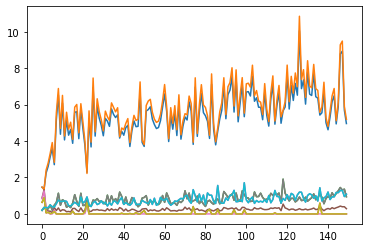

In [0]:
plt.plot(CS_loss)

In [0]:
MODEL_DIR = 'models/'
model_for_training_generator.save(MODEL_DIR+'model_for_training_generator_ep250_mnist.h5')
model_for_training_discriminator.save(MODEL_DIR+'model_for_training_discriminator_ep250_mnist.h5')
generator.save(MODEL_DIR+'generator_ep250_mnist.h5')
discriminator.save(MODEL_DIR+'discriminator_ep250_mnist.h5')

In [0]:
import joblib

LOSS_DIR = 'losses/'

joblib.dump(discriminator_loss,LOSS_DIR+'discriminator_loss_ep250_mnist.pkl')
joblib.dump(generator_loss,LOSS_DIR+'generator_loss_ep250_mnist.pkl')
joblib.dump(CS_loss,LOSS_DIR+'CS_loss_ep250_mnist.pkl')

['losses/CS_loss_ep250_mnist.pkl']